In [2]:
import keras
import theano as th
import theano
import theano.tensor as T
from keras import backend as K
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

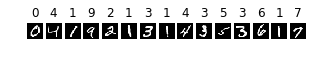

In [4]:
num_pics = 15
plt.figure(figsize=(5, 20))
for i in range(1, num_pics+1):
        plt.subplot(1, num_pics, i)
        plt.imshow(x_train[i], 'gray')
        plt.axis('off')
        plt.title(str(y_train[i]))

plt.show()

In [5]:
x_train = x_train.reshape(x_train.shape[0], np.prod(x_train.shape[1:]))
x_test = x_test.reshape(x_test.shape[0], np.prod(x_test.shape[1:]))

In [6]:
y_train_one_hot = keras.utils.to_categorical(y_train)
y_test_one_hot = keras.utils.to_categorical(y_test)

In [7]:
# To avoid too many transfer to the GPU, 
# place as many samples in shared variables
train_set_x = th.shared(np.asarray(x_train, dtype=th.config.floatX))
train_set_y = th.shared(np.asarray(y_train_one_hot, dtype='int32'))

# Simple Softmax Linear Model

In [8]:
num_output = y_train_one_hot.shape[1]
num_input =  x_train.shape[1]

In [9]:
x = T.matrix('x')
y = T.imatrix('y')

In [10]:
W = th.shared(value=np.random.rand(num_input, num_output),
             name='W', borrow=True)
b = th.shared(value=np.random.rand(num_output),
             name='b', borrow=True)

In [11]:
prob = T.nnet.softmax(x.dot(W) + b)

In [12]:
label_pred = T.argmax(prob, axis=-1)

In [13]:
xent = -T.mean(T.sum(
                    T.log(prob)*y, axis=-1)
              )

In [14]:
cost = T.nnet.nnet.categorical_crossentropy(prob, y).mean()

In [15]:
accu = T.mean(T.eq(label_pred, T.argmax(y, axis=-1)))

In [16]:
dW, db = T.grad(cost=cost, wrt=[W, b])

In [17]:
index = T.lscalar()
batch_size = 500
learning_rate = 0.05

In [18]:
single_layer_model = th.function(inputs=[index],
                                outputs=[xent, accu, cost],
                                updates=[(W, W - learning_rate*dW),
                                         (b, b - learning_rate*db)],
                                givens={
                                    x: train_set_x[index*batch_size:(index+1)*batch_size],
                                    y: train_set_y[index*batch_size:(index+1)*batch_size]
                                })

In [19]:
num_batches = x_train.shape[0] // batch_size
num_epochs = 1000
num_iters = num_batches * num_epochs
train_loss = np.zeros(num_iters)
train_accu = np.zeros(num_iters)

for epoch in range(num_epochs):
    for batch in range(num_batches):
        cur_iter_idx = epoch * num_batches + batch
        train_loss[cur_iter_idx], train_accu[cur_iter_idx], cur_cost = single_layer_model(batch)
        
    if epoch % 20 == 0:
        print("Epoch {}, minibatch {}/{}, training accu {:02.4f}%, training loss {}, current cost {}".format(
            epoch, batch, num_batches, train_accu[cur_iter_idx], train_loss[cur_iter_idx], cur_cost))

Epoch 0, minibatch 119/120, training accu 0.8640%, training loss 590.7203714124076, current cost 590.7203714124076
Epoch 20, minibatch 119/120, training accu 0.8900%, training loss 434.3788458149094, current cost 434.3788458149094
Epoch 40, minibatch 119/120, training accu 0.9060%, training loss 389.101008047792, current cost 389.101008047792


KeyboardInterrupt: 

In [72]:
y_test_pred = label_pred.eval({x: x_test})
np.mean(y_test == y_test_pred)

0.9053

# Two layer network

In [21]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [22]:
batch_size = 600
y_train_one_hot = keras.utils.to_categorical(y_train)
y_test_one_hot = keras.utils.to_categorical(y_test)
n_input = np.prod(x_train.shape[1:], dtype=np.int)
n_output = np.prod(y_train_one_hot[0].shape, dtype=np.int)

x_train_flatten = np.reshape(x_train, (x_train.shape[0], n_input))
x_test_flatten = np.reshape(x_test, (x_test.shape[0], n_input))

n_hidden = 500

In [23]:
def shared_glorot_uniform(shape, dtype=th.config.floatX, name='', n=None):
    if isinstance(shape, int):
        high = np.sqrt(6.0 / shape)
    else:
        high = np.sqrt(6.0 / (np.sum(shape[:2]) * np.prod(shape[2:])))
    shape = shape if n is None else (n,) + shape
    
    return th.shared(np.asarray(
                        np.random.uniform(low=-high, high=high, size=shape),
                        dtype=dtype),
                    name=name)

In [24]:
def shared_zeros(shape, dtype=th.config.floatX, name='', n=None):
    shape = shape if n is None else (n,) + shape
    return th.shared(np.zeros(shape, dtype=dtype), name=name)

In [25]:
train_set_x = th.shared(value=np.asarray(x_train_flatten, dtype=th.config.floatX))
train_set_y = th.shared(value=np.asarray(y_train_one_hot, dtype='int32'))

In [26]:
x = T.fmatrix()
t = T.imatrix()

In [27]:
idx = T.iscalar()

In [28]:
W1 = shared_glorot_uniform([n_input, n_hidden], name='W1')
b1 = shared_zeros((n_hidden, ), name='b1')

In [29]:
W2 = shared_glorot_uniform([n_hidden, n_output], name='W2')
b2 = shared_zeros((n_output, ), name='b2')

In [30]:
hidden_output = T.tanh(T.dot(x, W1) + b1)

In [31]:
P_output = T.nnet.softmax(T.dot(hidden_output, W2) + b2)

In [32]:
params = [W1, b1, W2, b2]

In [33]:
xent_cost = T.nnet.nnet.categorical_crossentropy(P_output, t).mean()

In [34]:
label_pred = T.argmax(P_output, axis=-1)
accu = T.mean(T.eq(label_pred, T.argmax(t, axis=-1)))

In [35]:
grad_params = T.grad(cost=xent_cost, wrt=params)

In [36]:
learning_rate = 0.01

In [37]:
updates = [
    (param, param - learning_rate * gparam)
    for param, gparam in zip(params, grad_params)
]

In [38]:
two_layer_model = th.function(inputs=[idx],
                         outputs=[P_output, accu, xent_cost],
                         updates=updates,
                         givens={
                             x: train_set_x[idx*batch_size: (idx+1)*batch_size],
                             t: train_set_y[idx*batch_size: (idx+1)*batch_size]
                         })

In [39]:
num_batches = x_train.shape[0] // batch_size
num_epochs = 100
num_iters = num_batches * num_epochs
train_accu = np.zeros(num_iters)

for epoch in range(num_epochs):
    for batch in range(num_batches):
        cur_iter_idx = epoch * num_batches + batch
        _, train_accu[cur_iter_idx], cur_cost = two_layer_model(batch)
        
    if epoch % 5 == 0:
        print("Epoch {}, minibatch {}/{}, training accu {:02.4f}%, current cost {}".format(
            epoch, batch, num_batches, train_accu[cur_iter_idx], cur_cost))

Epoch 0, minibatch 99/100, training accu 0.8917%, current cost 0.41295387585957843
Epoch 5, minibatch 99/100, training accu 0.9567%, current cost 0.21877751072247822
Epoch 10, minibatch 99/100, training accu 0.9700%, current cost 0.16829215308030446
Epoch 15, minibatch 99/100, training accu 0.9700%, current cost 0.14447964866956076
Epoch 20, minibatch 99/100, training accu 0.9767%, current cost 0.13046157479286194
Epoch 25, minibatch 99/100, training accu 0.9817%, current cost 0.11502652088801066
Epoch 30, minibatch 99/100, training accu 0.9833%, current cost 0.10192521373430888
Epoch 35, minibatch 99/100, training accu 0.9833%, current cost 0.0943093627691269
Epoch 40, minibatch 99/100, training accu 0.9833%, current cost 0.08802112996578217
Epoch 45, minibatch 99/100, training accu 0.9850%, current cost 0.0831730822722117
Epoch 50, minibatch 99/100, training accu 0.9850%, current cost 0.07962940653165182
Epoch 55, minibatch 99/100, training accu 0.9850%, current cost 0.07634475330511

In [40]:
y_test_pred = label_pred.eval({x: x_test_flatten})
np.mean(y_test == y_test_pred)

0.9508

# CNN

In [23]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_validate = x_train[55000:]
y_validate = y_train[55000:]
x_train = x_train[:55000]
y_train = y_train[:55000]

In [24]:
y_train_one_hot = keras.utils.to_categorical(y_train)
y_test_one_hot = keras.utils.to_categorical(y_test)

In [25]:
n_train_samples = x_train.shape[0]
n_test_samples = x_test.shape[0]
img_height, img_width = x_train.shape[1:]

In [26]:
x_train = x_train.reshape(n_train_samples, img_height, img_width)
x_test = x_test.reshape(n_test_samples, img_height, img_width)

In [27]:
from theano.tensor.signal import pool

In [28]:
class conv_layer:
    idx=0
    def __init__(self, input, input_shape=None, 
                 filter_shape=None, n_filters=1, border_mode='valid',
                activation=T.nnet.relu, name=None):
        
        if not name:
            W_name = 'Weight_' + str(conv_layer.idx) + '_conv'
            b_name = 'bias_' + str(conv_layer.idx) + '_conv'
            layer_name = 'conv' + '_' + str(conv_layer.idx) + '_conv'
            conv_layer.idx += 1
        else:
            W_name = 'Weight_' + name
            b_name = 'bias_' + name
            layer_name = name
    
        n_channels = input_shape[1]
        self._filter_shape = [n_filters, n_channels] + filter_shape

        self.W = shared_glorot_uniform(self._filter_shape, name=W_name)
        self.b = th.shared(np.asarray(np.random.normal(size=[n_filters,]),
                                      dtype=th.config.floatX),
                           name=name)
                         # broadcastable=(False, True, True))
        self._input_tensor = input
        self._border_mode = border_mode
        self._input_shape = input_shape
        self._activation = activation
        
    def __call__(self):
        conv_out = theano.tensor.nnet.conv2d(input=self._input_tensor,
                                           filters=self.W,
                                           input_shape=self._input_shape,
                                           filter_shape=self._filter_shape,
                                           border_mode=self._border_mode)
        out = self._activation(conv_out + self.b.dimshuffle('x', 0, 'x', 'x'))
        return out
    
    def weights(self):
        return [self.W, self.b]
    
    @property
    def name(self):
        return self.layer_name

In [29]:
batch_size = 500
x = T.tensor3(name='x')
t = T.ivector(name='t')
x_input = x.reshape([batch_size, 1, 28, 28])

In [30]:
conv1 = conv_layer(input=x_input, 
                   input_shape=[batch_size, 1, 28, 28],
                   n_filters=16,
                   filter_shape=[5, 5])
conv1_out = conv1()

In [31]:
pool1_out = pool.pool_2d(input=conv1_out, ws=[2, 2], ignore_border=True)

In [66]:
conv2 = conv_layer(input=pool1_out,
                  input_shape=[batch_size, 16, 12, 12],
                  n_filters=32,
                  filter_shape=[3, 3])
conv2_out = conv2()

TypeError: can only concatenate list (not "NoneType") to list

In [33]:
pool2_out = pool.pool_2d(input=conv2_out, ws=[2, 2], ignore_border=True)

In [34]:
flattened = pool2_out.flatten(2)

In [35]:
class fc_layer:
    idx = 0
    
    def __init__(self, input, input_length, output_length, 
                 name=None, activation=T.tanh):
              
        if not name:
            W_name = 'Weight_' + str(fc_layer.idx) + '_fc'
            b_name = 'bias_' + str(fc_layer.idx) + '_fc'
            layer_name = 'fc' + '_' + str(fc_layer.idx) + '_fc'
            fc_layer.idx += 1
        else:
            W_name = 'Weight_' + name
            b_name = 'bias_' + name
            layer_name = name

        
        self.W = shared_glorot_uniform((input_length, output_length), 
                                  name=W_name)
        self.b = shared_glorot_uniform((output_length, ), name=b_name)
        self._input = input
        self._activation = activation
        
    def __call__(self):
        out = self._activation(T.dot(self._input, self.W) + self.b)
        return out
    
    def weights(self):
        return [self.W, self.b]
    
    @property
    def name(self):
        return self.layer_name

In [36]:
import time
random_seed = int(time.time())
rng = np.random.RandomState(random_seed)
srng = T.shared_randomstreams.RandomStreams(rng.randint(999999))

In [37]:
dropout_rate = 0.5 

In [38]:
def dropout_layer(input, dropout_rate, size):
    if dropout_rate > 0:
        mask = srng.binomial(n=1, p=1-dropout_rate, size=size)
        return input * T.cast(mask, th.config.floatX)
    else:
        return input

In [39]:
flattened = dropout_layer(flattened, dropout_rate, flattened.shape)

In [40]:
fc1 = fc_layer(input=flattened, input_length=32*5*5, 
               output_length=500)
fc1_out = fc1()

In [41]:
fc1_out = dropout_layer(fc1_out, dropout_rate, fc1_out.shape)

In [42]:
fc2 = fc_layer(input=fc1_out, input_length=500, 
               output_length=10, activation=T.nnet.softmax)
fc2_out = fc2()

In [43]:
pred = T.argmax(fc2_out, axis=-1)
accu = T.mean(T.eq(pred, t))

In [44]:
conv1.W.set_value(saved_params[0].get_value())
conv1.b.set_value(saved_params[1].get_value())

conv2.W.set_value(saved_params[2].get_value())
conv2.b.set_value(saved_params[3].get_value())

fc1.W.set_value(saved_params[4].get_value())
fc1.b.set_value(saved_params[5].get_value())

fc2.W.set_value(saved_params[6].get_value())
fc2.b.set_value(saved_params[7].get_value())

NameError: name 'saved_params' is not defined

In [45]:
params = conv1.weights() + conv2.weights() + fc1.weights() + fc2.weights()

In [46]:
xent_cost = T.nnet.categorical_crossentropy(fc2_out, t).mean()

g_params = T.grad(cost=xent_cost, wrt=params)

### Training

In [47]:
def clip_norms(grads, clipnorm):
    norm = T.sqrt(sum([T.sum(g**2) for g in grads])) # L2 norm 
    return [T.switch(T.ge(norm, clipnorm), g*clipnorm / norm, g) for g in grads]

In [48]:
train_set_x = th.shared(np.asarray(x_train, dtype=th.config.floatX))
train_set_y = th.shared(np.asarray(y_train, dtype=th.config.floatX))
train_set_y = T.cast(train_set_y, 'int32')

In [49]:
cnn_validation_model = th.function(inputs=[x, t],
                              outputs=[xent_cost, accu])
cnn_predict = th.function(inputs=[x], outputs=[pred])

In [50]:
import theano_utils
updates = theano_utils.Adam_update(params=params, g_params=g_params, 
                                  learning_rate=0.005, forget_first=0.9, forget_second=0.999)

In [51]:
import theano_utils
updates = theano_utils.SGD(params=params, g_params=g_params, learning_rate=0.005)

In [52]:
import theano_utils
updates = theano_utils.RMSProp_update(params=params, g_params=g_params, learning_rate=0.005)

In [53]:
import theano_utils
updates = theano_utils.Adagra_update(params=params, g_params=g_params, learning_rate=0.005)

In [54]:
import theano_utils
updates = theano_utils.momentum_SGD_update(params=params, g_params=g_params, 
                                           learning_rate=0.005, alpha=0.2)

In [55]:
idx = T.iscalar('idx')

cnn_train_model = th.function(inputs=[idx],
                             outputs=[xent_cost, accu, pred],
                             updates=updates,
                             givens={
                                 x: train_set_x[idx*batch_size: (idx+1)*batch_size],
                                 t: train_set_y[idx*batch_size: (idx+1)*batch_size]
                             })

In [56]:
n_epochs = 150
n_batches = x_train.shape[0] // batch_size
n_iters = n_epochs * n_batches
train_cost_hist = []
train_acc_hist = []
train_prob_hist = []

In [57]:
validation_interval = 100
validate_n_batches = x_validate.shape[0] // batch_size
validate_cost_hist = []
validate_acc_hist = []

In [58]:
import timeit
start_time = timeit.default_timer()

for epoch in range(n_epochs):
    for cur_batch in range(n_batches):
        cur_iter = cur_batch + n_batches * epoch
        train_cost, train_acc, P = cnn_train_model(cur_batch)
        
        train_cost_hist.append(train_cost)
        train_acc_hist.append(train_acc)
        train_prob_hist.append(P)
        
        if (cur_iter % 20 == 0):
            print("train cost {:.8f}, train accuracy {:.8f} at epoch {} batch {}".format(
                    train_cost, train_acc, epoch, cur_batch))
        if cur_iter % validation_interval == 0:
            cur_val = cur_iter // validation_interval
            validate_cost, validate_acc = np.mean(
                [
                cnn_validation_model(
                x_validate[i * batch_size: (i+1)*batch_size],
                y_validate[i * batch_size: (i+1)*batch_size]
            ) for i in range(validate_n_batches)]
                , axis=0)
            
            validate_cost_hist.append(validate_cost)
            validate_acc_hist.append(validate_acc)
            
            print("validation cost {:.8f}, validation accuracy {:.8f}"
                  " at epoch {}, batch {}/{}".format(validate_cost,
                                                    validate_acc,
                                                    epoch, cur_batch, n_batches))
    
stop_time = timeit.default_timer()

print("Time Eplapsed", stop_time - start_time)

train cost 2.77397060, train accuracy 0.07800000 at epoch 0 batch 0
validation cost 2.76865323, validation accuracy 0.08980000 at epoch 0, batch 0/110
train cost 2.46411037, train accuracy 0.14200000 at epoch 0 batch 20
train cost 2.31486297, train accuracy 0.19000000 at epoch 0 batch 40
train cost 2.13718033, train accuracy 0.26200000 at epoch 0 batch 60
train cost 1.97736752, train accuracy 0.32800000 at epoch 0 batch 80
train cost 1.79910016, train accuracy 0.37800000 at epoch 0 batch 100
validation cost 1.70563624, validation accuracy 0.41080000 at epoch 0, batch 100/110
train cost 1.61909258, train accuracy 0.49000000 at epoch 1 batch 10
train cost 1.53799748, train accuracy 0.50200000 at epoch 1 batch 30
train cost 1.32491457, train accuracy 0.57600000 at epoch 1 batch 50
train cost 1.32018125, train accuracy 0.58400000 at epoch 1 batch 70
train cost 1.21176243, train accuracy 0.60800000 at epoch 1 batch 90
validation cost 1.12549598, validation accuracy 0.65260000 at epoch 1, ba

In [59]:
test_accs = np.mean([accu.eval({x: x_test[i*batch_size: (i+1)*batch_size],
                              t: y_test[i*batch_size: (i+1)*batch_size]})
            for i in range(x_test.shape[0] // batch_size)])
    
print(test_accs)

0.9755


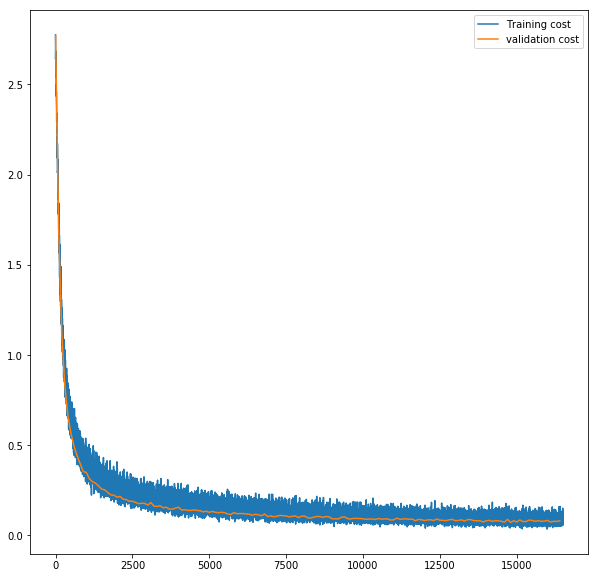

In [60]:
plt.figure(figsize=(10, 10))
plt.plot(np.arange(len(train_cost_hist)), train_cost_hist)
plt.plot(np.arange(len(validate_cost_hist))*validation_interval, validate_cost_hist)
plt.legend(['Training cost', 'validation cost'])
plt.savefig('Adagrad_cost.png')
plt.show()


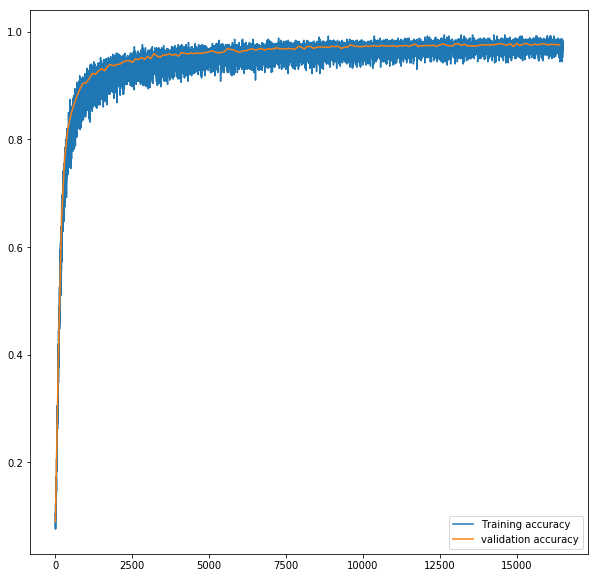

In [61]:
plt.figure(figsize=(10, 10))
plt.plot(np.arange(len(train_acc_hist)), train_acc_hist)

plt.plot(np.arange(len(validate_acc_hist))*validation_interval,
         validate_acc_hist)
plt.legend(['Training accuracy', 'validation accuracy'])
plt.savefig('Adagrad_acc.png')
plt.show()


In [62]:
np.equal(cnn_predict(x_test[:batch_size]), y_test[:batch_size])

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
      

In [63]:
import theano.misc.pkl_utils as pkl

In [64]:
with open('cnn_params.zip', 'wb') as f:
    pkl.dump(params, f)